### Нейронные сети.


In [1]:
import numpy as np
import scipy.stats as sps

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output


import torch
from torch import nn

import time

sns.set(font_scale=1.2, palette='Set2')
%matplotlib inline

In [52]:
model = nn.Sequential(
    nn.Linear(in_features=1, out_features=2),
    nn.Sigmoid(),
    nn.Linear(in_features=2, out_features=1)
)

Сгенерируем данные

In [53]:
sample_size = int(1e5)
X = sps.norm.rvs(size=(sample_size, 1))
X = torch.FloatTensor(X)

y = X**2 + torch.sin(3 * X)

assert y.shape == (sample_size, 1)

Разделим данные на тренировочную и тестовые части

In [54]:
from sklearn.model_selection import train_test_split

X, test, y, y_test = train_test_split(X, y, test_size=0.2)

In [55]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
optim_func = nn.MSELoss()

In [56]:
def show_progress(x, y, y_pred):
    y_pred = y_pred.detach()

    plt.figure(figsize=(10, 7))
    plt.scatter(x, y, alpha=0.75, label='function')
    plt.scatter(x, y_pred, color='orange', linewidth=5, label='prediction')
    plt.legend()
    plt.xlabel('аргумент')
    plt.ylabel('значение')
    plt.show()

In [57]:
def torch_model_fit(model, X, y, losses):
    num_iter = 8000

    for i in range(num_iter):

        y_pred = model(X)

        loss = optim_func(y_pred, y)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.item())
        
    return y_pred

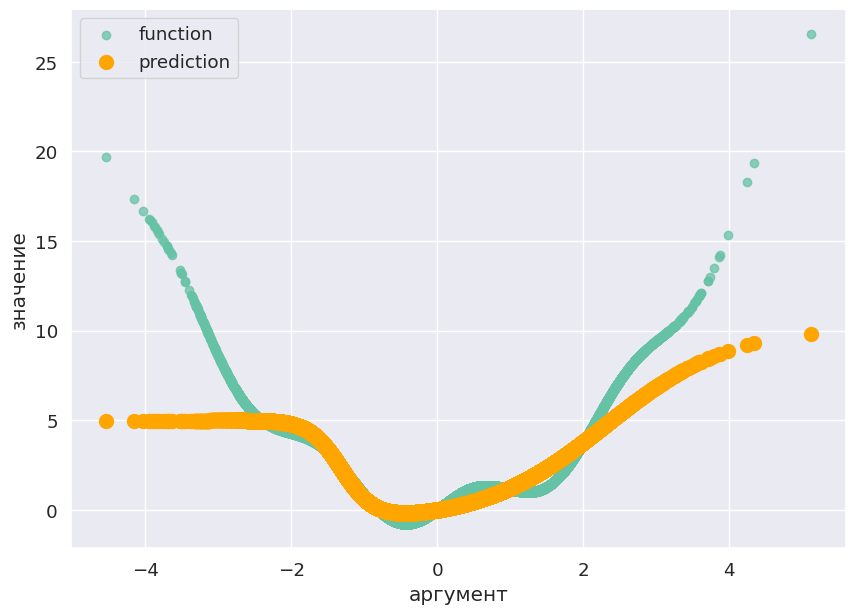

In [58]:
losses = []

y_pred = torch_model_fit(model, X, y, losses)

show_progress(X, y, y_pred)

Я сохранял loss после каждой итерации, чтобы отследить его изменения в процессе обучения. Построим график

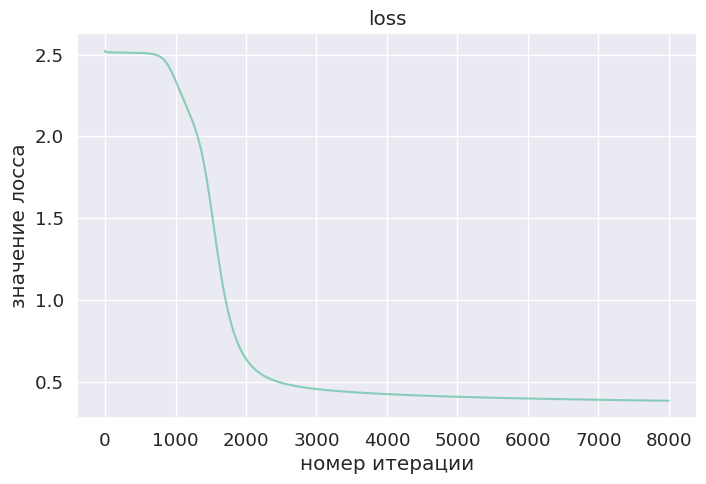

In [59]:
plt.figure(figsize=(8, 5))
plt.plot(range(len(losses)), losses, alpha=0.75, label='loss')
plt.xlabel('номер итерации')
plt.ylabel('значение лосса')
plt.title('loss')
plt.show()

MSE на тренировочных данных

In [60]:
optim_func(model(X), y).item()

0.3830030858516693

MSE на тестовых данных

In [61]:
optim_func(model(test), y_test).item()

0.3662673532962799

**Вывод:**

MSE на тестовых и тренировочных данных практически не отличаются

Показатель loss-а практически стабилизируется после какого-то момента, однако мы видим на графике, что искомая функция приближается неидеально. Это объясняется тем, что наша модель не достаточно сложная для такой функции. Однако всё же центральная часть графика функции довольно неплохо приближается, в отличие от краёв. Это можно объяснить тем, что данные нормально распределены и сосредоточены около 0, поэтому модель в первую очередь приближает значения именно в центральных точках

Довольно удобно работать с этим модулем, однако результаты обучения не всегда достигают хорошего качества. Одной из возможных причин может быть различная генерация начальных значений обучаемых параметров.

---
### <font color="orange"><i>Сложная часть</i></font>

### Реализация нейронной сети

In [69]:
def MSE(Y, Y_pred):
    n = len(Y)
    return ((Y - Y_pred) ** 2).sum() / n

Храним в модели обучаемые параметры, learning rates, массив loss-ов за время обучения для последующего исследования и начало времени обучения, чтобы отслеживать время обучения

In [80]:
class MyNeuralNetwork:
    def __init__(self):

        self.w11 = np.random.random_sample()
        self.w12 = np.random.random_sample()
        self.b11 = np.random.random_sample()
        self.b12 = np.random.random_sample()
        self.w21 = np.random.random_sample()
        self.w22 = np.random.random_sample()
        self.b2 = np.random.random_sample()
        self.lr_w = 0.01
        self.lr_b = 0.05
        self.losses = []
        self.time_of_fit = 0
        self.num_iter_ = 1000
        
    def sigmoid_(self, x):
        return 1 / (1 + np.exp(-x))
        
    def count_derivatives_(self, X, Y, Y_pred):
        """
        Вычисляет градиенты по всем параметрам
        X - входные данные
        Y - реальное значение таргета
        Y_pred - предсказанное значение таргета

        """
        
        n = len(X)

        d_yxi = 2 / n * (Y_pred - Y)
        
        self.d_b2 = d_yxi.sum()

        dy_dw21 = self.sigmoid_(self.w11 * X + self.b11)
        dy_dw22 = self.sigmoid_(self.w12 * X + self.b12)
        
        self.d_w21 = (d_yxi * dy_dw21).sum()
        self.d_w22 = (d_yxi * dy_dw22).sum()

        self.d_b11 = (d_yxi * self.w21 * dy_dw21 * (1 - dy_dw21)).sum()
        self.d_b12 = (d_yxi * self.w22 * dy_dw22 * (1 - dy_dw22)).sum()

        self.d_w11 = (d_yxi * self.w21 * dy_dw21 * (1 - dy_dw21) * X).sum()
        self.d_w12 = (d_yxi * self.w22 * dy_dw22 * (1 - dy_dw22) * X).sum()

    def update_params(self):
        """
        Обновляет все веса
        """
        self.b2 -= self.lr_b * self.d_b2
        self.w21 -= self.lr_w * self.d_w21
        self.w22 -= self.lr_w * self.d_w22
        
        self.b11 -= self.lr_b * self.d_b11
        self.b12 -= self.lr_b * self.d_b12
        self.w11 -= self.lr_w * self.d_w11
        self.w12 -= self.lr_w * self.d_w12        
    
    def fit_on_batch(self, X_batch, Y_batch):
        """
        Считает предсказания на батче, вычисляет градиенты, обновляет веса
        X_batch - батч набора данных
        Y_batch - реальный таргет батча
        """
        Y_batch_pred = self.predict(X_batch)
        self.count_derivatives_(X_batch, Y_batch, Y_batch_pred)
        self.update_params()
        return self
    
    def fit(self, X, Y, batch_size = len(X)):
        """
        Полный цикл обучения
        X - входные данные
        Y - Реальный таргет
        batch_size - размер батча (по умолчанию равен всему датасету)
        датасет перемешивается, далее для очередного батча берутся следующие k строк
        В конце каждой эпохи считается общий лосс
        """
        fit_start = time.time()
        self.losses = []

        for epoch_num in range(self.num_iter_):
            indices = range(len(X))
    
            if (batch_size < len(X)):
                indices = np.random.permutation(len(X))
            
            for batch_num in range(0, len(X), batch_size):
                self.fit_on_batch(X[indices[batch_num : batch_num + batch_size]],
                                  Y[indices[batch_num : batch_num + batch_size]])
            
            Y_pred = self.predict(X)
            loss = MSE(Y, Y_pred)
            self.losses.append(loss)
        
        self.time_of_fit = time.time() - fit_start
        return self
        
    
    def predict(self, X):
        """
        Вычисляет предсказания на наборе данных X
        Возвращает предсказания
        """
        U1 = self.sigmoid_(self.w11 * X + self.b11)
        U2 = self.sigmoid_(self.w12 * X + self.b12)
        predictions = self.w21 * U1 + self.w22 * U2 + self.b2

        return predictions
    
    def initialize_params(self, params_values):
        """
        Инициализирует начальные значения обучаемых параметров заданным набором params_values
        """        
        self.w11, self.w12, self.w21, self.w22, self.b11, self.b12, self.b2 = params_values
        
        
    def set_num_iter(self, num_iter):
        """
        Инициализирует количество эпох
        """
        self.num_iter_ = num_iter

Обучим написанную модель, используя обучение на батчах размера 256 (для примера, потом исследуем, какой размер батча оптимальный). Я передаю размер батча при обучении модели, если он равен размеру выборки или же вообще не передаётся, то обучение происходит стандартным образом без деления на батчи

In [71]:
my_model = MyNeuralNetwork()
my_model.fit(X, y, 256)

Обучим на тех же данных линейную регрессию

In [72]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X, y)
k = lin_model.coef_[0][0]
b = lin_model.intercept_[0]

Обучим pytorch-нейросеть

In [73]:
t_model = nn.Sequential(
    nn.Linear(in_features=1, out_features=2),
    nn.Sigmoid(),
    nn.Linear(in_features=2, out_features=1)
)

optimizer = torch.optim.SGD(t_model.parameters(), lr=0.05)
optim_func = nn.MSELoss()

t_X = torch.FloatTensor(X)
t_y = torch.FloatTensor(y)

losses = []

t_pred = torch_model_fit(t_model, t_X, t_y, losses)
t_pred = t_pred.detach()

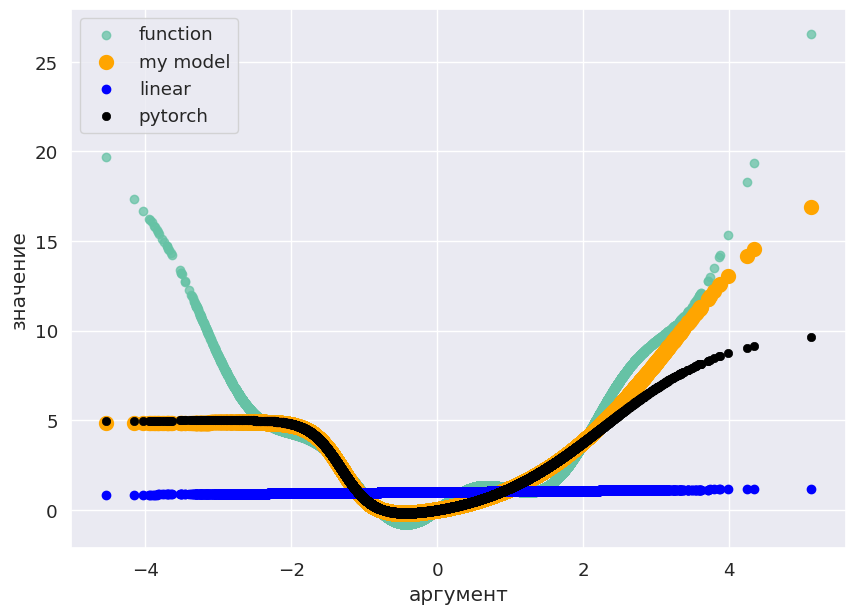

In [79]:
plt.figure(figsize=(10, 7))
plt.scatter(X, y, alpha=0.75, label='function')
plt.scatter(X, my_model.predict(X), color='orange', linewidth=5, label='my model')
plt.scatter(X, X * k + b, color='blue', linewidth=1, label='linear')
plt.scatter(X, t_pred, color='black', linewidth=0.5, label='pytorch')
plt.xlabel('аргумент')
plt.ylabel('значение')
plt.legend()
plt.show()

Обе нейросети неплохо приблизили функцию. Линейная регрессия ожидаемо задачу решила плохо

In [75]:
print('linear loss: ', MSE(y, X * k + b).item())
print('pytorch loss: ', MSE(y, t_pred).item())
print('my model loss: ', MSE(y, my_model.predict(X)).item())

linear loss:  2.511965274810791
pytorch loss:  0.3850308656692505
my model loss:  0.34081727266311646


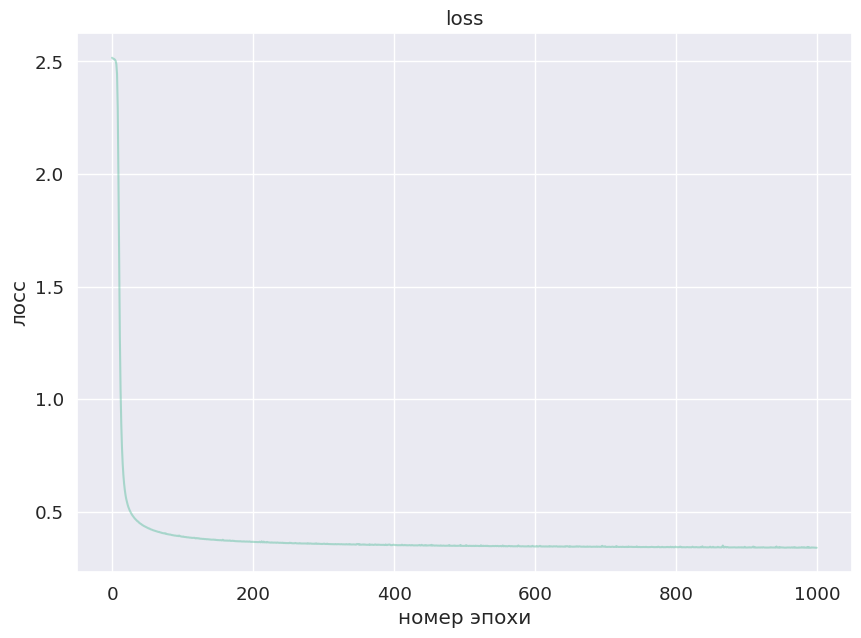

In [78]:
plt.figure(figsize=(10, 7))
plt.plot(range(len(my_model.losses)), my_model.losses, alpha=0.5, label='loss')
plt.xlabel('номер эпохи')
plt.ylabel('лосс')
plt.title('loss')
plt.show()

На начальных итерациях лосс оставался на прежнем уровне, потом резко упал и продолжал плавно снижаться до конца обучения. Теперь исследуем зависимость времени обучения и итогового лосса от размера батча. Чтобы обеспечить одинаковые стартовые условия для корректности эксперимента, будем вручную проставлять начальные обучаемые параметры, сгенерированные предварительно

In [21]:
times = []
batch_losses = []
batch_sizes = np.logspace(4, 12, num=9, base=2)
batch_sizes = list(batch_sizes) + [len(X)]
coefs = [0] * 7
for i in range(7):
    coefs[i] = np.random.random_sample()


for batch_size in batch_sizes:
    model_test_batch_size = MyNeuralNetwork()
    model_test_batch_size.initialize_params(coefs)
    model_test_batch_size.fit(X, y, int(batch_size))
    batch_losses.append(model_test_batch_size.losses[-1])
    times.append(model_test_batch_size.time_of_fit)

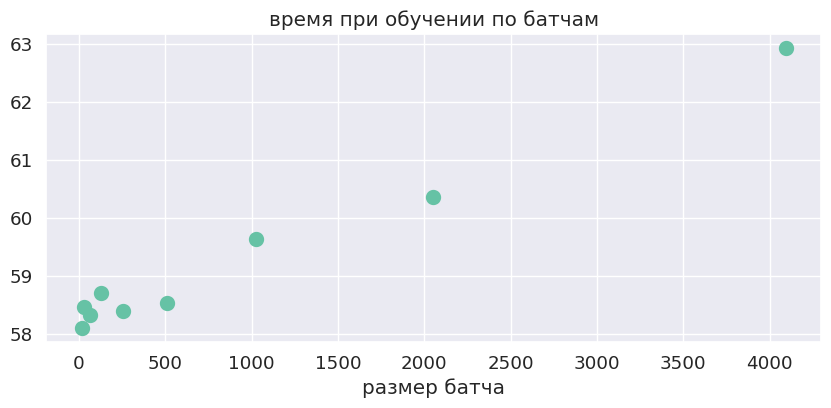

In [46]:
plt.figure(figsize=(10, 4))
plt.scatter(batch_sizes[:-1], times[:-1], linewidth=5, label='times')
plt.xlabel('размер батча')
plt.title('время при обучении по батчам')
plt.show()

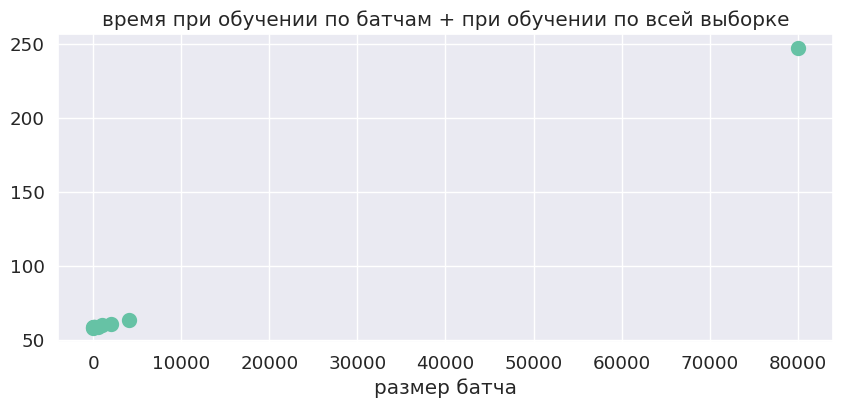

In [47]:
plt.figure(figsize=(10, 4))
plt.scatter(batch_sizes, times, linewidth=5, label='times')
plt.xlabel('размер батча')
plt.title('время при обучении по батчам + при обучении по всей выборке')
plt.show()

При обучении по батчам время увеличивается при большем размере, но не так значительно. Если же берём всю выборку, то время обучения превышает оптимизированное обучение в 5 раз

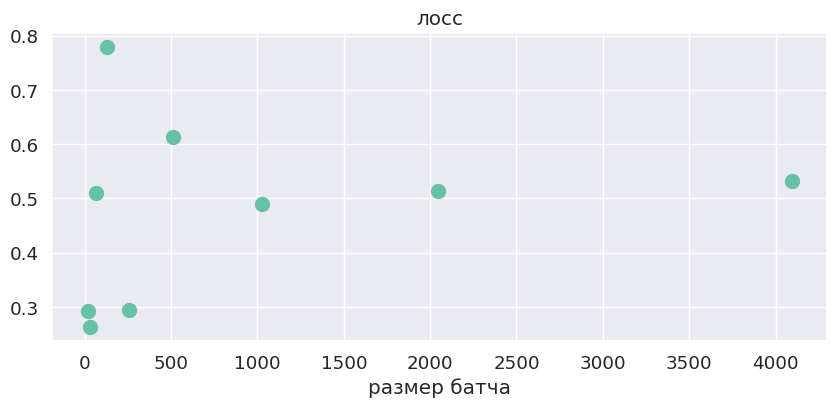

In [49]:
plt.figure(figsize=(10, 4))
plt.scatter(batch_sizes[:-1], batch_losses[:-1], linewidth=5, label='losses')
plt.xlabel('размер батча')
plt.title('лосс')
plt.show()

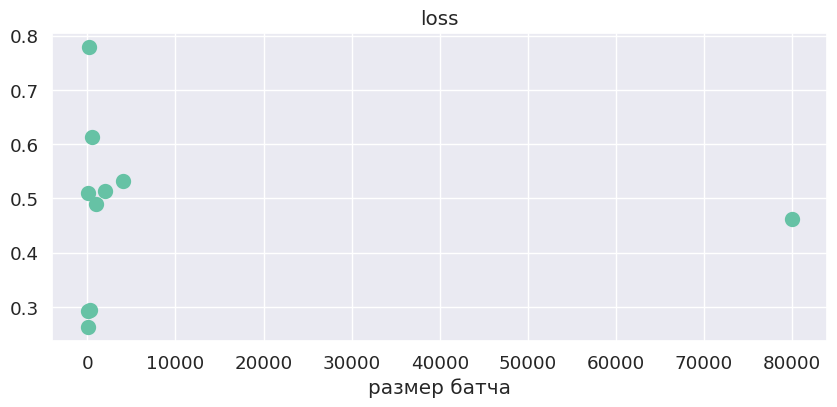

In [50]:
plt.figure(figsize=(10, 4))
plt.scatter(batch_sizes, batch_losses, linewidth=5, label='losses')
plt.xlabel('размер батча')
plt.title('loss')
plt.show()

При размерах батча < 1000 лосс на тренировочной части данных нестабилен, колеблется от 0.3 до 0.8. Лосс при обучении на всей выборке чуть меньше 0.5, поэтому модели с батчами > 1000 довольно точны. Время обучения при размерах батчей < 5000 не сильно отличается от меньших размеров, поэтому оптимальным выбором выглядит размер батча 2048 (возьмём степень двойки)

(Я вижу, что на двух из верхних графиков много пустого места, но для анализа полезно было рассмотреть не очень большие значения размера батчей, а также всю выборку)

In [24]:
MSE(y, my_model.predict(X)).item()

0.5001920461654663

In [25]:
MSE(y_test, my_model.predict(test)).item()

0.4578406810760498

Так как время обучения модели получилось значительно уменьшить, увеличим число итераций с 8000 до 15000 для уверенности в стабилизации лосса

In [51]:
sample_size = int(1e5)
X = sps.norm.rvs(size=(sample_size, 1))
X = torch.FloatTensor(X)

y = (X + 1)*(X - 0.25)*torch.cos(2*X - 1)

X, test, y, y_test = train_test_split(X, y, test_size=0.2)

my_model = MyNeuralNetwork()
my_model.set_num_iter(15000)
my_model.fit(X, y, 2048)

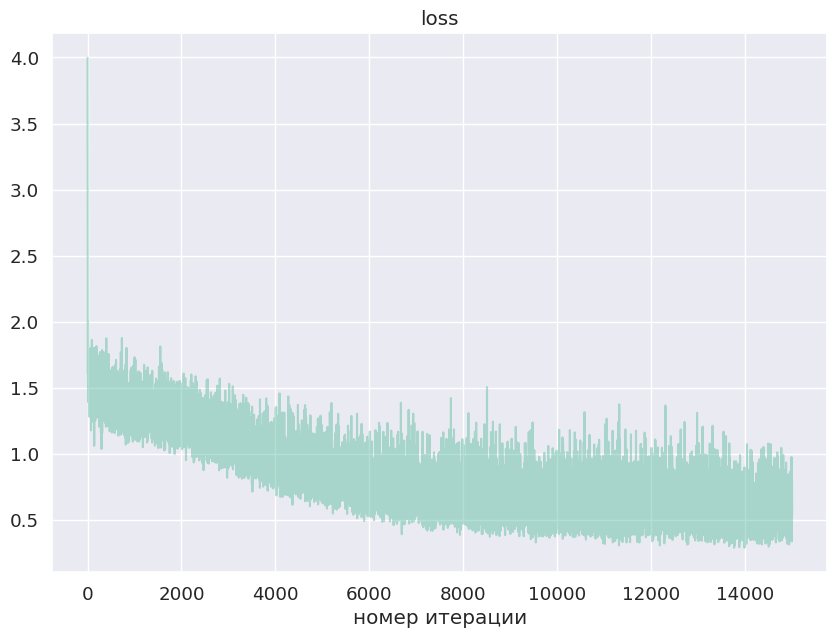

In [52]:
plt.figure(figsize=(10, 7))
plt.plot(range(len(my_model.losses)), my_model.losses, alpha=0.5, label='loss')
plt.xlabel('номер итерации')
plt.title('loss')
plt.show()

Лосс стабилизировался, но 8000 итераций не хватило бы, поэтому увеличение итераций до 15000 было не зря

In [53]:
lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X, y)
k = lin_model.coef_[0][0]
b = lin_model.intercept_[0]

In [54]:
t_model = nn.Sequential(
    nn.Linear(in_features=1, out_features=2),
    nn.Sigmoid(),
    nn.Linear(in_features=2, out_features=1)
)

optimizer = torch.optim.SGD(t_model.parameters(), lr=0.05)
optim_func = nn.MSELoss()

t_X = torch.FloatTensor(X)
t_y = torch.FloatTensor(y)

losses = []

t_pred = torch_model_fit(t_model, t_X, t_y, losses)
t_pred = t_pred.detach()

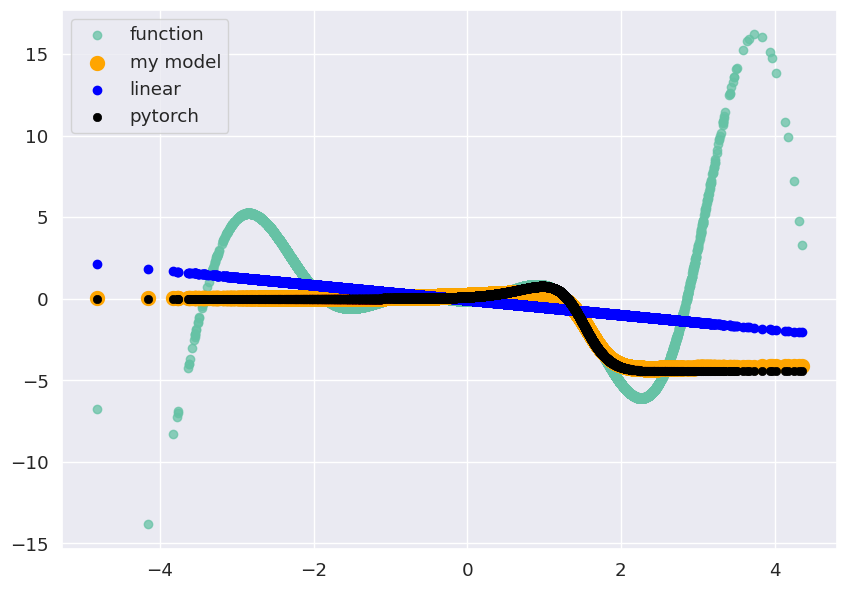

In [55]:
plt.figure(figsize=(10, 7))
plt.scatter(X, y, alpha=0.75, label='function')
plt.scatter(X, my_model.predict(X), color='orange', linewidth=5, label='my model')
plt.scatter(X, X * k + b, color='blue', linewidth=1, label='linear')
plt.scatter(X, t_pred, color='black', linewidth=0.5, label='pytorch')
plt.legend()
plt.show()

In [56]:
print('linear loss: ', MSE(y, X * k + b).item())
print('pytorch loss: ', MSE(y, t_pred).item())
print('my model loss: ', MSE(y, my_model.predict(X)).item())

linear loss:  1.2990812063217163
pytorch loss:  0.5492610335350037
my model loss:  0.5775937438011169


In [57]:
MSE(y, my_model.predict(X)).item()

0.5775937438011169

In [58]:
MSE(y_test, my_model.predict(test)).item()

0.5753260850906372

**Вывод:**
1. На тестовых данных моя модель показала себя даже лучше, чем на тренировочных

2. Реализованная мной модель приближает заданные функции не хуже pytorch-модели. Модель подстраивается под значения в точках наибольшего скопления тренировочных данных, так как это уменьшает loss

3. Графики изменения лосса при обучении по всей выборке и по батчам значительно отличаются. В первом случае график гладкий и равномерный, во втором - значительно колеблющийся, но всё же имеющий тенденцию на убывание

4. Время обучения увеличиввается при увеличении размера батча, но на значениях меньших 5000 почти не отличается, зато его значительно превосходит время обучения по всей выборке (в 5 раз)

5. При обучении по батчам мы можем подобрать их оптимальный размер, так чтобы значительно выиграть во времени обучения, при этом не проиграв в точности. Кроме того, благодаря этому мы можем увеличить количество итераций (эпох) обучения. Как видно на графике изменения лосса, уже после 8000 эпох лосс практически стабилизировался, но даже увеличив число эпох с 8000 до 15000, взяв батч размером 2048, мы всё равно выиграли по времени примерно в 3 раза (по сравнению с обучением по всей выборке)

Комментарий: в ходе работы я использовал термины "обучение по батчам" и "обучение по всей выборке". Конечно, я понимаю, что даже при обучении с использованием выбора батча мы обучаемся на всей выборке (ну, почти, некоторые значения могут никогда не испольоваться из-за случайности, это можно исправить изначальным перемешиванием строк и последующим выбором подряд идущих значений). Просто мне было удобно так говорить